# Jack’s Car Rental

---
A solution to Jack's car rental problem

In [1]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from jax import random
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

jnp.set_printoptions(suppress=True, linewidth=100)

In [10]:
# Discount rate
γ = 0.9
# Rate of request
λ_req_a, λ_req_b = 3, 4
# Rate of return
λ_ret_a, λ_ret_b = 3, 2

# Maximum number of cars allowed at any location
max_cars = 20
# Maximum number of cars that are allowed to be moved overnight
max_car_move = 5

# MDP:
# timestep: days
# state: number of cars at each location at the end of the day
# actions: net number of cars moved between the two locations overnight

To solve this problem, we must first determine the grid of possible values given by

$$
    p(s'_a, s'_b, r \vert s_a, s_b, a)
$$

* $\mathcal A = \{-5, -4, \ldots, 5\}$
* $\mathcal R = \left\{10, -2n\right\}$, where $n$ is the number of cars moved overnight

## Some experiments

In [5]:
S_a, S_b  = 10, 20

In [6]:
key = random.PRNGKey(314)

key_ret_a, key_req_a, key_ret_b, key_req_b = random.split(key, 4)

n_days = 500

returned_a = random.poisson(key_ret_a, λ_ret_a, (n_days,))
requested_a = random.poisson(key_req_a, λ_req_a, (n_days,))

returned_b = random.poisson(key_ret_b, λ_ret_b, (n_days,))
requested_b = random.poisson(key_req_b, λ_req_b, (n_days,))

In [7]:
def reduce_hist(state, xs):
    new_state = jnp.clip(state + xs, 0, 20)
    return new_state, new_state

### Inventory simulation

Assuming that there is no interaction between locations `a` and `b`, the following plot shows a simulation on the number of cars at each location at the end of the day.

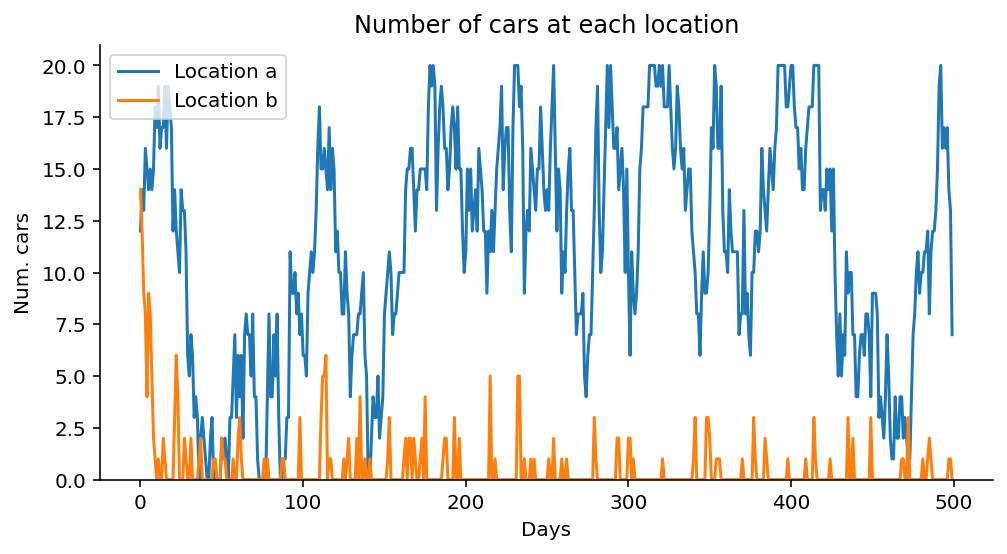

In [7]:
Δa = returned_a - requested_a
Δb = returned_b - requested_b

_, hist_a = jax.lax.scan(reduce_hist, S_a, Δa)
_, hist_b = jax.lax.scan(reduce_hist, S_b, Δb)

plt.subplots(1, 1, figsize=(8, 4))
plt.plot(hist_a, label="Location a")
plt.plot(hist_b, label="Location b")
plt.ylim(0, 21)
plt.legend()
plt.ylabel("Num. cars")
plt.xlabel("Days")
plt.title("Number of cars at each location");

## Computing probabilities

The claim is that

$$
    p(s_b' \vert s_b, a) = \text{Skellam}\left(s_b' - s_b -  a \vert \lambda_b^\text{ret}, \lambda_b^\text{req}\right) \mathbb{1}\big(0 \leq s_b' \leq 20\big)
$$

In [8]:
def prob_a(sa_prime, sa, action):
    dist = tfp.distributions.Skellam(λ_ret_a, λ_req_a)
    return dist.prob(sa_prime - sa - action) * (0 <= sa_prime) * (sa_prime <= 20)

In [9]:
sa = 3
a = 5

sa_prime_samp = sa + a + returned_a - requested_a
sa_prime_samp = (sa + a + returned_a - requested_a) * (0 <= sa_prime_samp) * (sa_prime_samp <= 20)

Computing the distribution of the number of cars at location `a` at the end of the day assuming that $s_a = 3$ and $a = 5$

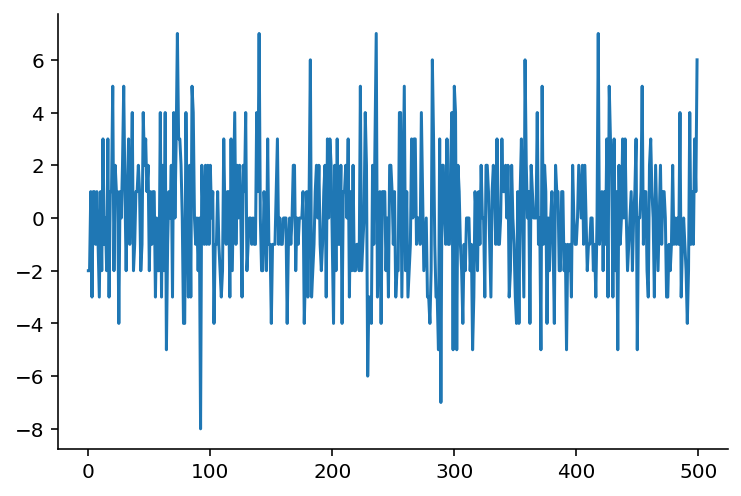

In [10]:
plt.plot(requested_a -  returned_a)

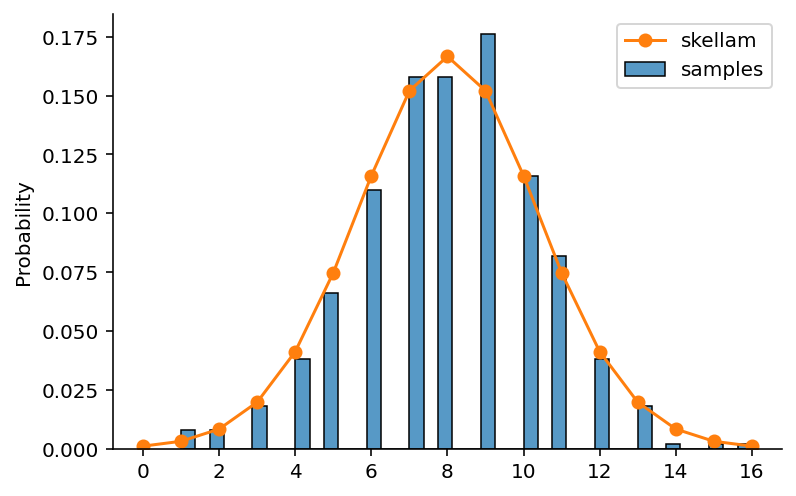

In [11]:
net_move_a = jnp.arange(0, 17).astype(float)

sns.histplot(sa_prime_samp, stat="probability", bins=40, label="samples")
plt.plot(net_move_a, prob_a(net_move_a, sa, a), c="tab:orange", marker="o", label="skellam")
plt.legend();

In [12]:
def prob_a(sa_prime, sa, action):
    """
    Probabiliy of moving `action` cars from location a -> location b
    """
    dist = tfp.distributions.Skellam(λ_ret_a, λ_req_a)
    return dist.prob(sa_prime - sa - action) * (0 <= sa_prime) * (sa_prime <= 20)

def prob_b(sb_prime, sb, action):
    """
    Probabiliy of moving `action` cars from location b -> location a
    """
    dist = tfp.distributions.Skellam(λ_ret_b, λ_req_b)
    return dist.prob(sb_prime - sb + action) * (0 <= sb_prime) * (sb_prime <= 20)

def p_move(action, sa, sb):
    return (sa >= action) * (sb >= -action)

In [13]:
sa = 1
sb = 0

actions = jnp.arange(-5, 6)
actions

DeviceArray([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5], dtype=int32)

In [14]:
for action in actions:
    val = p_move(action, sa, sb)
    print(f"{action:2}: {val}")

-5: False
-4: False
-3: False
-2: False
-1: False
 0: True
 1: True
 2: False
 3: False
 4: False
 5: False


In [15]:
arange = jnp.arange(-5, 6).astype(float)
vrange = jnp.arange(0, 21).astype(float)
req_range = jnp.arange(20).astype(float)
ret_range = jnp.arange(20).astype(float)

$$
    p(s_a', s_b', n \vert s_a, s_b, a) = \text{Skellam}(s_a' - s_a + a \vert \lambda^\text{ret}_a, \lambda^\text{req}_a) \times \text{Skellam}(s_b' - s_b - a \vert \lambda^\text{ret}_b, \lambda^\text{req}_b)
\times \text{pois}\left((n + 2a)/10, \lambda^\text{req}_a + \lambda^\text{req}_b\right)
$$

In [16]:
def p_transition_a(state_prime, state, action):
    dist = tfp.distributions.Skellam(λ_ret_a, λ_req_a)
    return dist.prob(state_prime - state + action) * (0 >= state_prime) * (state_prime <= 20)

def p_transition_b(state_prime, state, action):
    dist = tfp.distributions.Skellam(λ_ret_b, λ_req_b)
    return dist.prob(state_prime - state - action) * (0 >= state_prime) * (state_prime <= 20)

def p_move(action, sa, sb):
    return (sa >= action) * (sb >= -action)

@jax.jit
def p(sa_prime, sb_prime, n_req, sa, sb, action):
    pois = tfp.distributions.Poisson(rate=λ_req_a + λ_req_b)
    prob_req = pois.prob(n_req) * (sa + sb >= n_req)
    
    return (p_transition_a(sa_prime, sa, action) * p_transition_b(sb_prime, sb, action) *
            p_move(action, sa, sb))

In [17]:
num_params = 6

# outer-product-like vmap over each of the entires of the distribution
pv = p
for n in range(num_params):
    vals = [0 if i==n else None for i in range(num_params)]
    pv = jax.vmap(pv, vals, out_axes=-1)
    
#              sa',    sb',      n    | sa,      sb,   action
p_grid = pv(vrange, vrange, req_range, vrange, vrange, arange)
# Z_grid = p_grid.sum(axis=0, keepdims=True).sum(axis=1, keepdims=True).sum(axis=2, keepdims=True)
# p_grid = jnp.nan_to_num(p_grid / Z_grid, posinf=0, neginf=0)

In [18]:
p_grid[..., 0, 1, 5].sum()

DeviceArray(0.5213302, dtype=float32)

In [19]:
array_reward =  10 * req_range[:, None] - 2 * jnp.abs(arange[None, :])
# n, action
array_reward.shape

(20, 11)

In [20]:
value_array = jnp.zeros((21, 21))
# sa', sb'
value_array.shape

(21, 21)

In [21]:
reward_value = array_reward[None, None, ...] + γ * value_array[..., None, None]
# sa', sb', n, action
reward_value.shape

(21, 21, 20, 11)

In [22]:
# ** Initial policy **
# In the initial policy we assume that we will not be moving
# cars between lots
policy = jnp.zeros((11, 21, 21)) # (action, sa, sb)
policy = policy.at[5].set(1)

# ** Initial value function **
value_array = jnp.zeros((21, 21))

Indices' naming
```
a: sa
b: sb
c: action
i: sa'
j: sb'
k: n-requested
l: n-returned
```

In [23]:
for _ in range(20):
    reward_value = array_reward[None, None, ...] + γ * value_array[..., None, None]
    value_array = jnp.einsum("cab,ijkabc,ijkc->ab", policy, p_grid, reward_value)

In [24]:
value_array.sum()

DeviceArray(1489.0033, dtype=float32)

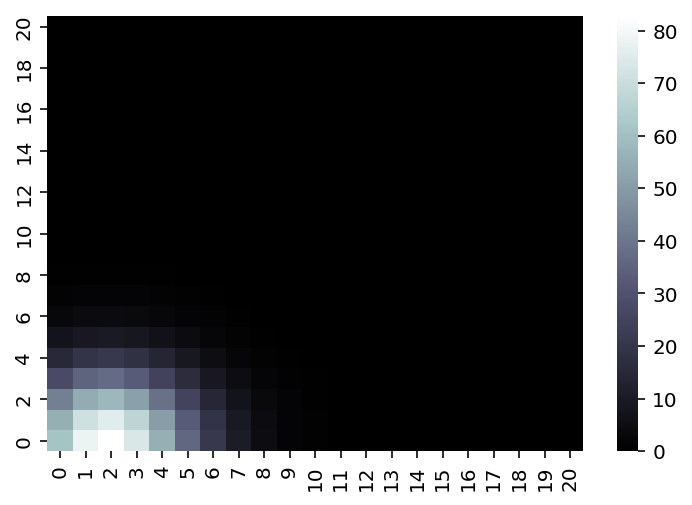

In [25]:
ax = sns.heatmap(value_array, cmap="bone")
plt.xticks(rotation=90)
ax.invert_yaxis()

## Policy improvement

$$
    v_{\pi'}(s_a, s_b) = \max_a \sum_{s_a', s_b', n} p(s_a', s_b', n_\text{req} \vert s_a, s_b, a)\left[10n_\text{req} - 2a + \gamma v_\pi(s_a', s_b')\right]
$$

In [26]:
reward_value = array_reward[None, None, ...] + γ * value_array[..., None, None]
q_improv = jnp.einsum("ijkabc,ijkc->cab", p_grid, reward_value)

In [27]:
# Update value function
value_array = q_improv.max(axis=0)

# Policy improvment
policy = jnp.zeros((11, 21, 21))
policy = jax.nn.one_hot(q_improv.argmax(axis=0), 11, axis=0)

In [28]:
jnp.set_printoptions(precision=5, linewidth=500)

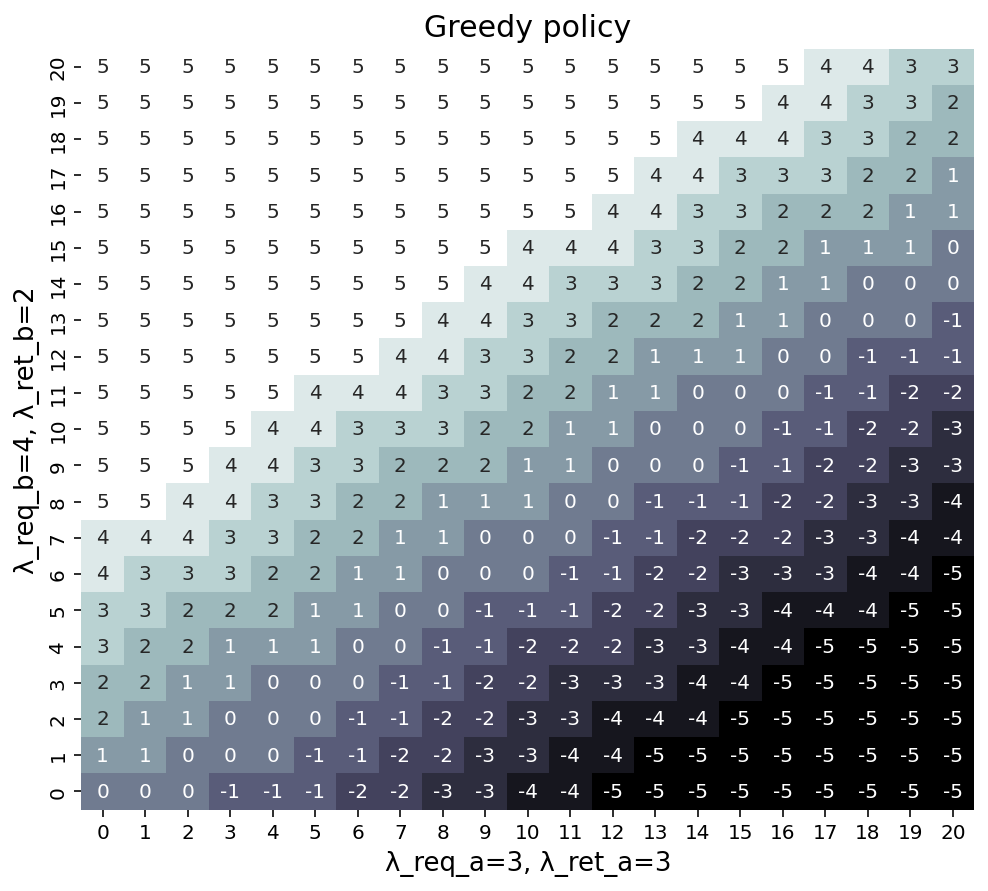

In [29]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(q_improv.argmax(axis=0) - 5, cmap="bone", annot=True, cbar=False, ax=ax)
ax.invert_yaxis()
ax.set_title("Greedy policy", fontsize=15)
ax.set_xlabel(f"{λ_req_a=}, {λ_ret_a=}", fontsize=13)
ax.set_ylabel(f"{λ_req_b=}, {λ_ret_b=}", fontsize=13);

# Second try

We will model the transition probabilities of $s_a$ and $s_b$ separately, i.e., we will compute

$$
\begin{aligned}
    &p(s_a', s_b', r \vert s_a, s_b, a) = \sum_{\phi_a, \phi_b}\sum_{\varphi_a, \varphi_b} p(s_a', s_b', r, \phi_a, \phi_b, \varphi_a, \varphi_b \vert s_a, s_b, a) \\
    &= \sum_{\phi_a, \varphi_a} p(\phi_a) p(\varphi_a) p(s_a' \vert \phi_a, \varphi_a, s_a, a) \sum_{\phi_b, \varphi_b} p(\phi_b) p(\varphi_b) p(s_b' \vert \phi_b, \varphi_b, s_b, a) p(r \vert \varphi_a, \varphi_b, a) \\
    &= \sum_{\phi_a} p(\phi_a) \sum_{\phi_b} p(\phi_b) \sum_{\varphi_a, \varphi_b} p(\varphi_a) p(\varphi_b)  p(s_a' \vert \phi_a, \varphi_a, s_a, a)  p(s_b' \vert \phi_b, \varphi_b, s_b, a) p(r \vert \varphi_a, \varphi_b, a)
\end{aligned}
$$

Where

* $p(\phi_a) = \text{Pois}(\phi_a \vert \lambda^\text{ret}_a)$
* $p(\varphi_a) = \text{Pois}(\varphi_a \vert \lambda^\text{req}_a)$

* $p(\phi_b) = \text{Pois}(\phi_b \vert \lambda^\text{ret}_b)$
* $p(\varphi_b) = \text{Pois}(\varphi_b \vert \lambda^\text{req}_b)$

* $p(s_a' \vert \phi_a, \varphi_a, s_a, a) = \mathbb{1}(s_b' = s_a - a + \phi_a - \varphi_a) \mathbb{1}(0 \leq s_a' \leq 20)$
* $p(s_b' \vert \phi_b, \varphi_b, s_b, a) = \mathbb{1}(s_b' = s_b + a + \phi_b - \varphi_b) \mathbb{1}(0 \leq s_b' \leq 20)$
* $p(r \vert \varphi_a, \varphi_b, a) = \mathbb{1}(r = 10 (\varphi_a + \varphi_b) - 2 \vert a \vert)$

In [3]:
def pr_transition_a(n_ret, n_req):
    p_ret = tfd.Poisson(λ_ret_a).prob(n_ret)
    p_req = tfd.Poisson(λ_req_a).prob(n_req)
    return p_ret * p_req

def pr_transition_b(n_ret, n_req):
    p_ret = tfd.Poisson(λ_ret_b).prob(n_ret)
    p_req = tfd.Poisson(λ_req_b).prob(n_req)
    return p_ret * p_req

In [4]:
from jax.experimental import loops

max_elements = 20
discount = 0.9

@jax.jit
def value_function(state, action_array, value_grid, discount):
    state_a, state_b = state
    action = action_array.argmax() - 5
    
    action_clipped = jnp.clip(action, -state_b, state_a)
    is_valid_action = action == action_clipped
    
    with loops.Scope() as s:
        s.expected_reward = -2.0 * jnp.abs(action)
        for n_ret_a in s.range(max_elements):
            for n_req_a in s.range(max_elements):
                for n_ret_b in s.range(max_elements):
                    for n_req_b in s.range(max_elements):
                        
                        pr = pr_transition_a(n_ret_a, n_req_a) * pr_transition_b(n_ret_b, n_req_b)
                                                
                        sa_prime = state_a - action
                        sb_prime = state_b + action
                        
                        n_req_a = jnp.minimum(sa_prime, n_req_a)
                        n_req_b = jnp.minimum(sb_prime, n_req_b)
                                                
                        sa_prime = sa_prime + n_ret_a - n_req_a
                        sb_prime = sb_prime + n_ret_b - n_req_b
                        
                        sa_prime = jnp.clip(sa_prime, 0, 20)
                        sb_prime = jnp.clip(sb_prime, 0, 20)

                        reward = 10.0 * (n_req_a + n_req_b)
                            
                        value_config = reward + discount * value_grid[sa_prime, sb_prime]
                        s.expected_reward += pr * value_config
                        
    return s.expected_reward * is_valid_action

In [8]:
# ** Initial policy **
# In the initial policy we assume that we will not be moving
# cars between lots
policy = jnp.zeros((11, 21, 21)) # (action, sa, sb)
policy = policy.at[5].set(1)
value_array = jnp.zeros((21, 21))

In [9]:
%%time
value_function(jnp.asarray([5, 10]), jax.nn.one_hot(5, 11), value_array, discount).block_until_ready()

CPU times: user 852 ms, sys: 0 ns, total: 852 ms
Wall time: 1.55 s


DeviceArray(68.5956, dtype=float32)

In [5]:
vmap_value_function = jax.vmap(value_function, (1, 1, None, None), out_axes=0)
vmap_value_function = jax.vmap(vmap_value_function, (2, 2, None, None), out_axes=1)

In [10]:
vrange = jnp.mgrid[:21, :21]
discount = 0.9

In [11]:
jnp.abs(jnp.zeros((21, 21)) - value_array).max()

DeviceArray(0., dtype=float32)

In [12]:
with loops.Scope() as s:
    s.value_array = value_array
    for _ in s.range(10):
        s.value_array = vmap_value_function(vrange, policy, s.value_array, discount)
value_array = s.value_array

## To-do: Write for loop

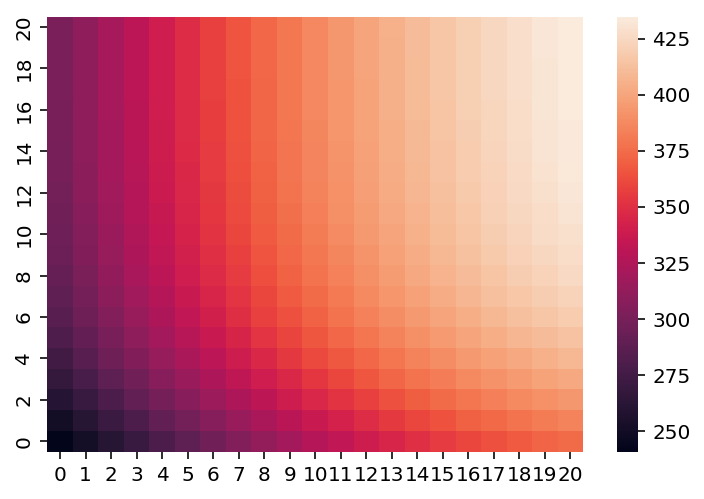

In [13]:
ax = sns.heatmap(value_array)
ax.invert_yaxis()

In [6]:
improv_value_function = jax.vmap(value_function, (1, None, None, None), out_axes=0)
improv_value_function = jax.vmap(improv_value_function, (2, None, None, None), out_axes=1)
improv_value_function = jax.vmap(improv_value_function, (None, 0, None, None), out_axes=2)

# def improv_value_function(state, value_array, discount):
#     arange_ix = jnp.eye(11).astype(int)
#     return improv_value_function(state, arange_ix, value_array, discount) 

In [12]:
# arange_ix = jnp.arange(11)
# arange_ix = jax.nn.one_hot(arange_ix, 11)
arange_ix = jnp.eye(11).astype(int)

In [18]:
q_improv = improv_value_function(vrange, arange_ix, value_array, discount).block_until_ready()

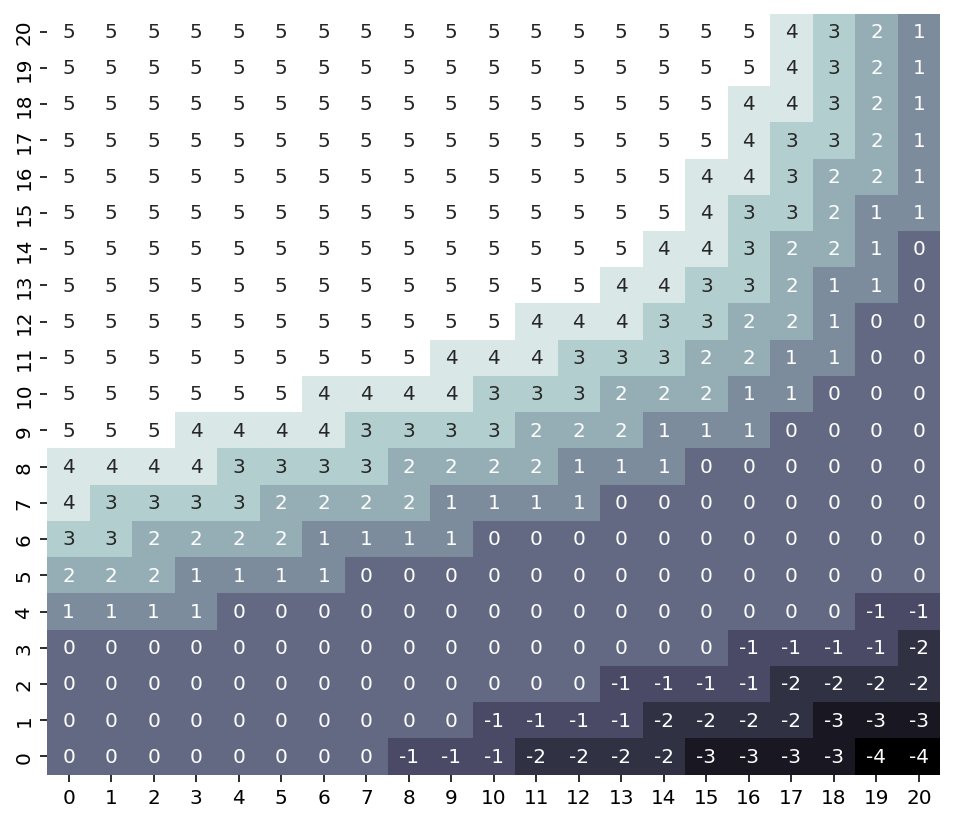

In [19]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(q_improv.argmax(axis=-1) - 5, annot=True, ax=ax, cbar=False, cmap="bone")
ax.invert_yaxis()

In [20]:
new_policy_ix = q_improv.argmax(axis=-1)
policy = jnp.transpose(jax.nn.one_hot(new_policy_ix, 11), (2, 0, 1))

# All together

In [1]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from jax import random
from jax.experimental import loops
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

jnp.set_printoptions(suppress=True, linewidth=100)

In [3]:
# Discount rate
γ = 0.9
# Rate of request
λ_req_a, λ_req_b = 3, 4
# Rate of return
λ_ret_a, λ_ret_b = 3, 2

# Maximum number of cars allowed at any location
max_cars = 20
# Maximum number of cars that are allowed to be moved overnight
max_car_move = 5

# MDP:
# timestep: days
# state: number of cars at each location at the end of the day
# actions: net number of cars moved between the two locations overnight

In [4]:
def pr_transition_a(n_ret, n_req):
    p_ret = tfd.Poisson(λ_ret_a).prob(n_ret)
    p_req = tfd.Poisson(λ_req_a).prob(n_req)
    return p_ret * p_req

def pr_transition_b(n_ret, n_req):
    p_ret = tfd.Poisson(λ_ret_b).prob(n_ret)
    p_req = tfd.Poisson(λ_req_b).prob(n_req)
    return p_ret * p_req

In [5]:
max_elements = 20
discount = 0.9

@jax.jit
def value_function(state, action_array, value_grid, discount):
    state_a, state_b = state
    action = action_array.argmax() - 5
    
    action_clipped = jnp.clip(action, -state_b, state_a)
    is_valid_action = action == action_clipped
    
    with loops.Scope() as s:
        s.expected_reward = -2.0 * jnp.abs(action)
        for n_ret_a in s.range(max_elements):
            for n_req_a in s.range(max_elements):
                for n_ret_b in s.range(max_elements):
                    for n_req_b in s.range(max_elements):
                        
                        pr = pr_transition_a(n_ret_a, n_req_a) * pr_transition_b(n_ret_b, n_req_b)
                                                
                        sa_prime = state_a - action
                        sb_prime = state_b + action
                        
                        n_req_a = jnp.minimum(sa_prime, n_req_a)
                        n_req_b = jnp.minimum(sb_prime, n_req_b)
                                                
                        sa_prime = sa_prime + n_ret_a - n_req_a
                        sb_prime = sb_prime + n_ret_b - n_req_b
                        
                        sa_prime = jnp.clip(sa_prime, 0, 20)
                        sb_prime = jnp.clip(sb_prime, 0, 20)

                        reward = 10.0 * (n_req_a + n_req_b)
                            
                        value_config = reward + discount * value_grid[sa_prime, sb_prime]
                        s.expected_reward += pr * value_config
                        
    return s.expected_reward * is_valid_action

In [6]:
vmap_value_function = jax.vmap(value_function, (1, 1, None, None), out_axes=0)
vmap_value_function = jax.vmap(vmap_value_function, (2, 2, None, None), out_axes=1)

In [7]:
improv_value_function = jax.vmap(value_function, (1, None, None, None), out_axes=0)
improv_value_function = jax.vmap(improv_value_function, (2, None, None, None), out_axes=1)
improv_value_function = jax.vmap(improv_value_function, (None, 0, None, None), out_axes=2)

## Iteration

In [8]:
# ** Initial policy **
# In the initial policy we assume that we will not be moving
# cars between lots
policy = jnp.zeros((11, 21, 21)) # (action, sa, sb)
policy = policy.at[5].set(1)
value_array = jnp.zeros((21, 21))
vrange = jnp.mgrid[:21, :21]
discount = 0.9
arange_ix = jnp.eye(11).astype(int) # Fixed array to pass to the policy-improvement scheme

In [10]:
@jax.jit
def update(value_array, policy, discount, max_err=0.1, eps=1e-6):
    with loops.Scope() as s:
        s.value_array = value_array
        s.err = max_err + 1.0
        s.ix = 0
        for _ in s.while_range(lambda: s.err > max_err):
            update_value_array = vmap_value_function(vrange, policy, s.value_array, discount)
            s.err = jnp.abs(update_value_array / (s.value_array + eps) - 1).max()
            s.value_array = update_value_array
            s.ix += 1
    return s.ix, s.value_array

In [16]:
threshold = 0.95
value_array = jnp.zeros((21, 21))
policy_ix = jnp.zeros((21, 21))
policy_hist = []

In [17]:
ix = 0
is_stable = False
policy_hist_ix = []
threshold = 0.95

while not is_stable:
    print(f"it: {ix+1:02}")
    nsteps, value_array = update(value_array, policy, discount)
    q_improv = improv_value_function(vrange, arange_ix, value_array, discount).block_until_ready()
    curr_threshold = (policy_ix == q_improv.argmax(axis=-1)).mean().item()
    is_stable = curr_threshold >= threshold
    policy_ix = q_improv.argmax(axis=-1)
    policy = jnp.transpose(jax.nn.one_hot(policy_ix, 11), (2, 0, 1))
    print(f"threshold: {curr_threshold:0.2%}", end="\n\n")
    policy_hist_ix.append(policy_ix)
    ix += 1

it: 01
threshold: 0.00%

it: 01
threshold: 38.55%

it: 01
threshold: 86.62%

it: 01
threshold: 97.05%



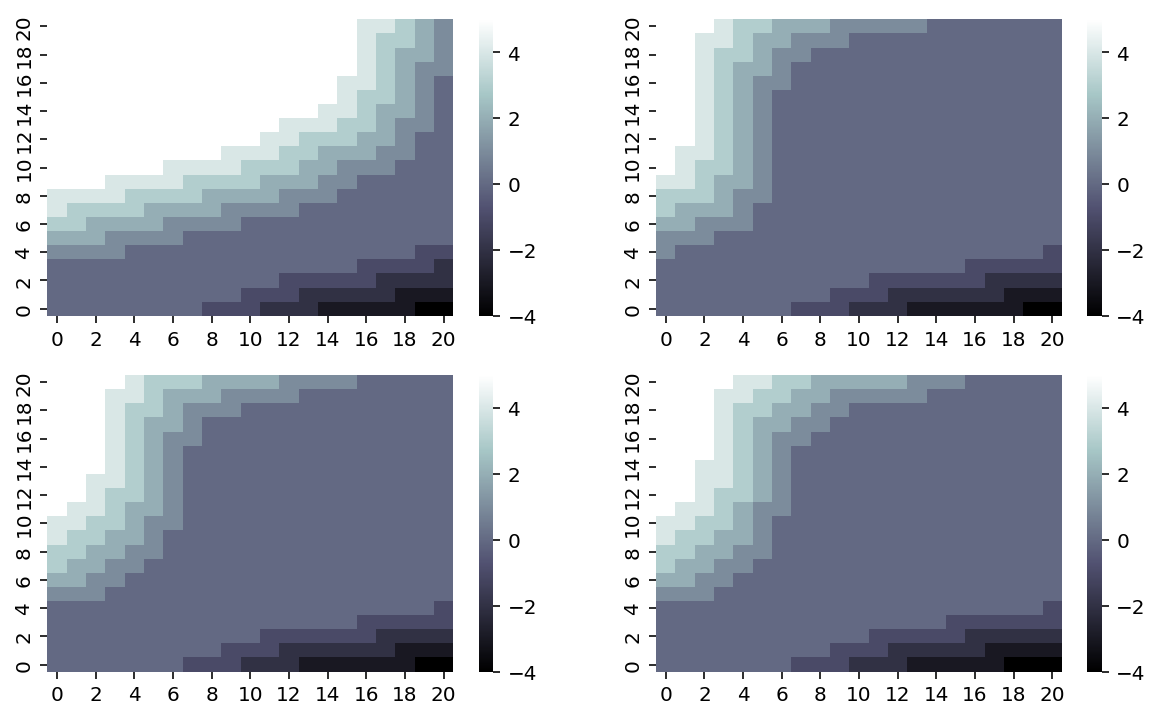

In [41]:
policy_hist = jnp.stack(policy_hist_ix, axis=0) - 5
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.ravel()
for axi, policy_i in zip(ax, policy_hist):
    sns.heatmap(policy_i, ax=axi, cbar=True, cmap="bone")
    axi.invert_yaxis()

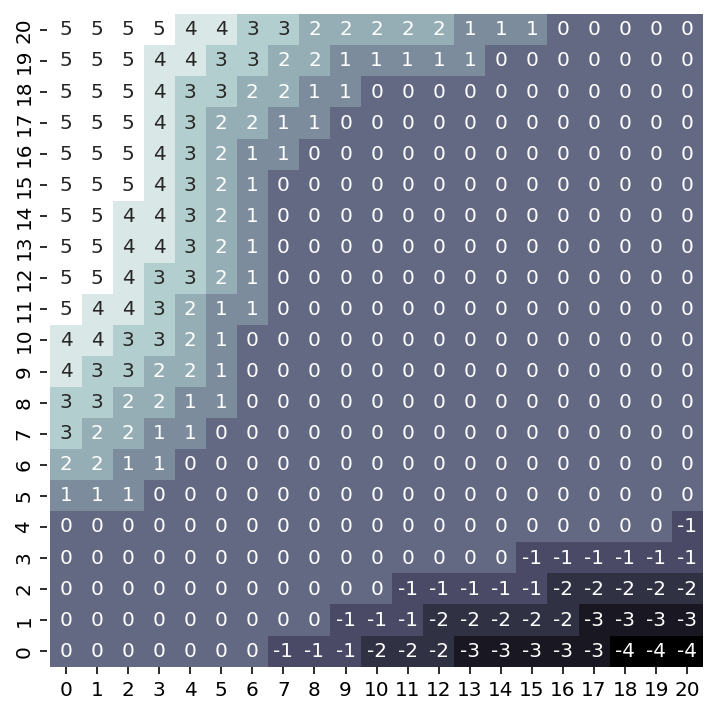

In [44]:
fig, ax = plt.subplots(figsize=(5.9, 6))
sns.heatmap(policy_hist[-1], cmap="bone", cbar=False, ax=ax, annot=True)
ax.axis("equal")
ax.invert_yaxis()

# References

* https://towardsdatascience.com/elucidating-policy-iteration-in-reinforcement-learning-jacks-car-rental-problem-d41b34c8aec7
* https://jax.readthedocs.io/en/latest/jax.experimental.loops.html